In [357]:
# Synapse Classification Challenge
# Introduction to Connectomics 2018
# Elliot Yang Liu (your name here)

your_name = 'liu_elliot'
!pip install mahotas
!pip install ndparse
%matplotlib inline

In [358]:
# Load data

import numpy as np

data = np.load('./synchallenge2017_training.npz')

imtrain = data['imtrain']
annotrain = data['annotrain']
ytrain = data['ytrain']

data = np.load('./synchallenge2017_validation.npz')

imvalid = data['imvalid']
annovalid = data['annovalid']
yvalid = data['yvalid']

In [359]:
# Define feature extraction code

import skimage.feature as skif

def extract_features(imdata):
    xtrain = []
    for im in imdata:
        fvector = []
        # 35th percentile based on intensity
        fvector.append(np.percentile(im,35))
       
        
        # add a contrast feature
        g = skif.greycomatrix(im, [0, 2], [0, np.pi/2],normed=True, symmetric=True)
        asm = skif.greycoprops(g, 'ASM')

        # explict way to add feature elements one at a time
        asm = np.ravel(asm)
        for i in asm:
            fvector.append(i)
            
        #fvector.append(skif.blob_dog(im))
        #blob = np.ravel(skif.blob_dog(im))
        #for i in blob:
        #    fvector.append(i)
        
        #fvector.append(skif.shape_index(im))
        
        #fvector.append(skif.hessian_matrix_det(im, sigma = 1))
        #hess = skif.hessian_matrix_det(im, sigma = 1)
        #hess = np.ravel(hess)
        #for k in hess:
        #   fvector.append(k)
        
        #canny = skif.canny(im, sigma = 20)
        #canny = np.ravel(canny)
        #for j in canny:
        #    fvector.append(j)

        #ckr = skif.corner_kitchen_rosenfeld(im, mode='wrap')
        #ckr = np.ravel(ckr)
        #for j in ckr:
        #    fvector.append(j)
            
        #hlf = skif.haar_like_feature(im,100,100,500,500)
        #hlf = np.ravel(hlf)
        #for j in hlf:
        #    fvector.append(j)
            
        cst = skif.corner_shi_tomasi(im, sigma=5)
        cst = np.ravel(cst)
        for j in cst:
            fvector.append(j)
        
        #fvector.append(np.ravel(skif.hog(im, visualise=None)))
        
        #fvector.append(skif.local_binary_pattern(im, 2, 2, method='default'))
        lbp = skif.local_binary_pattern(im, 10, 10, method='default')
        lbp = np.ravel(lbp)
        for k in lbp:
            fvector.append(k)

        fvector = np.asarray(fvector)
        xtrain.append(fvector)
        

        
    return np.asarray(xtrain)
    

In [360]:
# Extract Features from training

xtrain = extract_features(imtrain)
# Train Classifier

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(xtrain, ytrain)


In [361]:
# Extract features from validation set
xvalid = extract_features(imvalid)


In [362]:
# Run Classifier on validation set
scoresvalid = clf.predict_proba(xvalid)

In [363]:
# Best f1 score report on validation set

from sklearn.metrics import f1_score

# Can add post-processing here if desired

prob_syn = scoresvalid[:,1]

# default threshold
print('default f1 score: {}'.format(np.round(f1_score(yvalid, prob_syn >=0.5),2)))

f1_out = 0
thresh = 0
for i in np.arange(0.0, 1, 0.05):
    f1_test =  f1_score(yvalid, prob_syn > i)
    if f1_test > f1_out:
        f1_out = f1_test
        thresh = i

print('My best validation f1-score is: {} at {} threshold.'.format(np.round(f1_out,2), thresh))

default f1 score: 0.89
My best validation f1-score is: 0.89 at 0.45 threshold.


synapse present - true positive


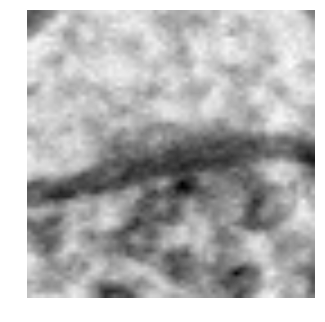

no synapse present - true negative


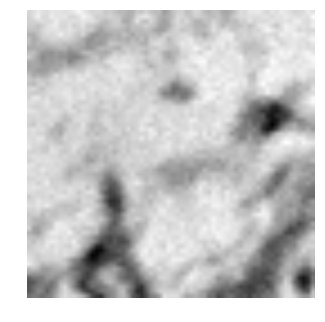

synapse present - false negative


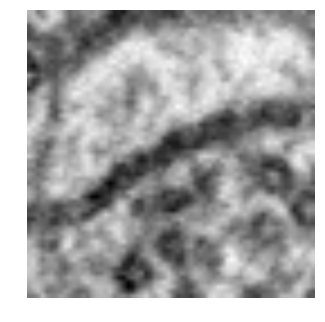

no synapse present - false positive


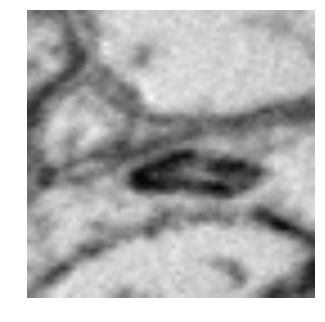

In [364]:
# here we can inspect results

valid_labels = np.asarray(prob_syn > thresh,dtype='int')
# find images we did well on
idx_correct_syn = np.where((valid_labels == yvalid) & (yvalid == 1))[0]
idx_correct_nosyn = np.where((valid_labels == yvalid) & (yvalid == 0))[0]
# find images we did poorly on

idx_wrong_syn = np.where((valid_labels != yvalid) & (yvalid == 1))[0]
idx_wrong_nosyn = np.where((valid_labels != yvalid) & (yvalid == 0))[0]
import ndparse as ndp

print('synapse present - true positive')
ndp.plot(imvalid[idx_correct_syn[3]])

print('no synapse present - true negative')
ndp.plot(imvalid[idx_correct_nosyn[3]])

print('synapse present - false negative')
ndp.plot(imvalid[idx_wrong_syn[3]])

print('no synapse present - false positive')
ndp.plot(imvalid[idx_wrong_nosyn[3]])

In [365]:
# Validate performance on test set (should only run/score once!)

data = np.load('./synchallenge2017_test_notruth.npz')

imtest = data['imtest']
annotest = data['annotest']

# Extract features from test set
xtest = extract_features(imtest)

# Run classifier on test set
scoretest = clf.predict_proba(xvalid)

# Post-processing
prob_syntest = scoretest[:,1]
syntest_predict = prob_syntest > thresh
syntest_predict = np.asarray(syntest_predict,dtype = 'uint8')

# save file and upload to google docs with label vector
np.save(your_name+'_synchallenge_testdata.npy',syntest_predict)